In [124]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm

from n3fit.model_gen import pdfNN_layer_generator
from n3fit.io.writer import XGRID

from validphys.api import API

In [125]:
tf.autograph.set_verbosity(0)
np.random.seed(0)

In [126]:
# Number of networks to initialize with random parameters
number_of_networks = 500

In [127]:
# input xgrid for which to produce the corresponding outputs
input_xgrid = XGRID.reshape(1,-1)

In [128]:
# read basis settings from a fit runcard (optional, but basis_info is useful)
fit_info = API.fit(fit="NNPDF40_nnlo_as_01180_1000").as_input()

basis_info = fit_info["fitting"]["basis"]

nodes = fit_info["parameters"]["nodes_per_layer"]
activations = fit_info["parameters"]["activation_per_layer"]
initializer_name = fit_info["parameters"]["initializer"]
layer_type = fit_info["parameters"]["layer_type"]
dropout = fit_info["parameters"]["dropout"]

In [129]:
nn_outputs = []
for i in tqdm(range(number_of_networks)):
    # Initialize the NNPDF model with given hyperparameters
    pdf_model = pdfNN_layer_generator(
        inp=2,
        nodes=[25, 20, 8],
        activations=['tanh','tanh','linear'],
        initializer_name="glorot_normal",
        layer_type="dense",
        flav_info=basis_info,
        fitbasis="EVOL",
        out=14,
        seed=np.random.randint(0, pow(2, 31)),
        dropout=0.0,
        regularizer=None,
        regularizer_args=None,
        impose_sumrule="All",
        scaler=None,
        parallel_models=1,
    )

    # Generate predictions in 14-flavor basis
    out = pdf_model[0].predict( {"pdf_input": input_xgrid}, verbose=False)

    # transform to 8 flavor basis: sigma, g, v, v3, v8, t3, t8, t15
    out = out[0,:,[1,2,3,4,5,9,10,11]]
    nn_outputs.append(out)
nn_outputs = np.array(nn_outputs)

100%|██████████| 500/500 [07:54<00:00,  1.05it/s]


# Plots

In [130]:
# plot settings
pdf_names = ["\Sigma", "g", "V", "V3", "V8", "T3", "T8", "T15"]
color = "C0"

<Figure size 640x480 with 0 Axes>

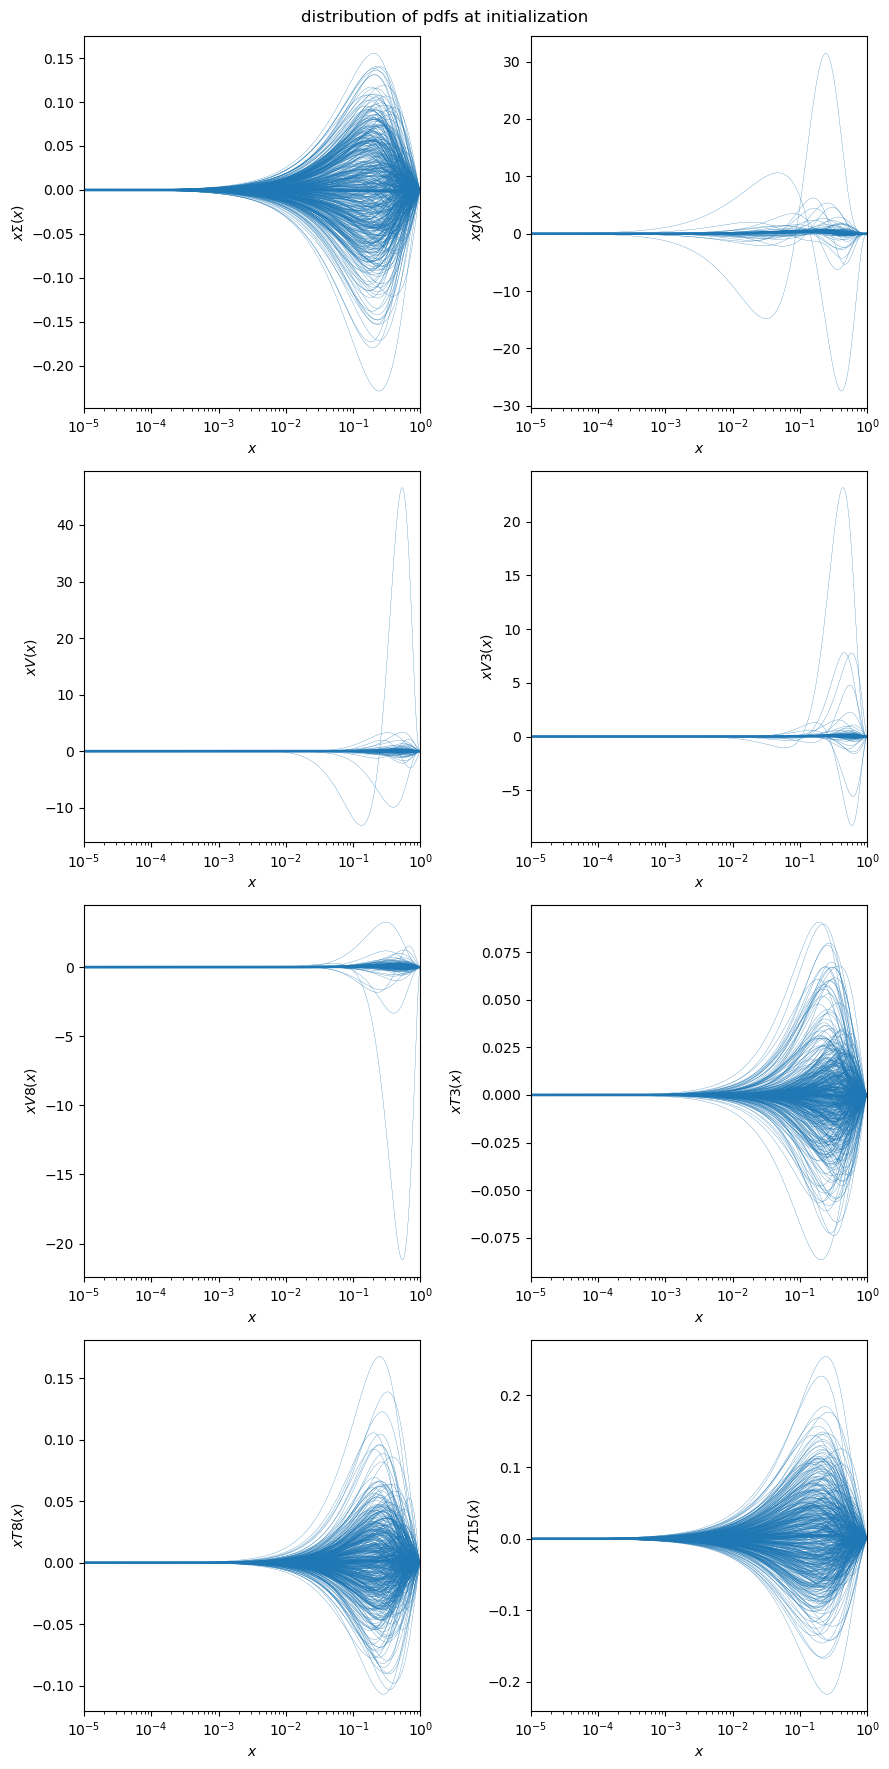

In [131]:
plt.clf()
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 18))
for i, (name, ax) in enumerate(zip(pdf_names, axs.flatten())):
    ax.plot(input_xgrid[0], input_xgrid.T*nn_outputs[:,i,:].T, color=color, lw=0.2)
    pdf_cv = nn_outputs[:,i,:].mean(axis=0)
    ax.plot(input_xgrid[0], input_xgrid[0]*pdf_cv, color=color, lw=2)
    ax.set_xscale("log")
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(rf"$x{name}(x)$")
    ax.set_xlim(1e-5,1)

fig.suptitle("distribution of pdfs at initialization\n")
fig.tight_layout()

<Figure size 640x480 with 0 Axes>

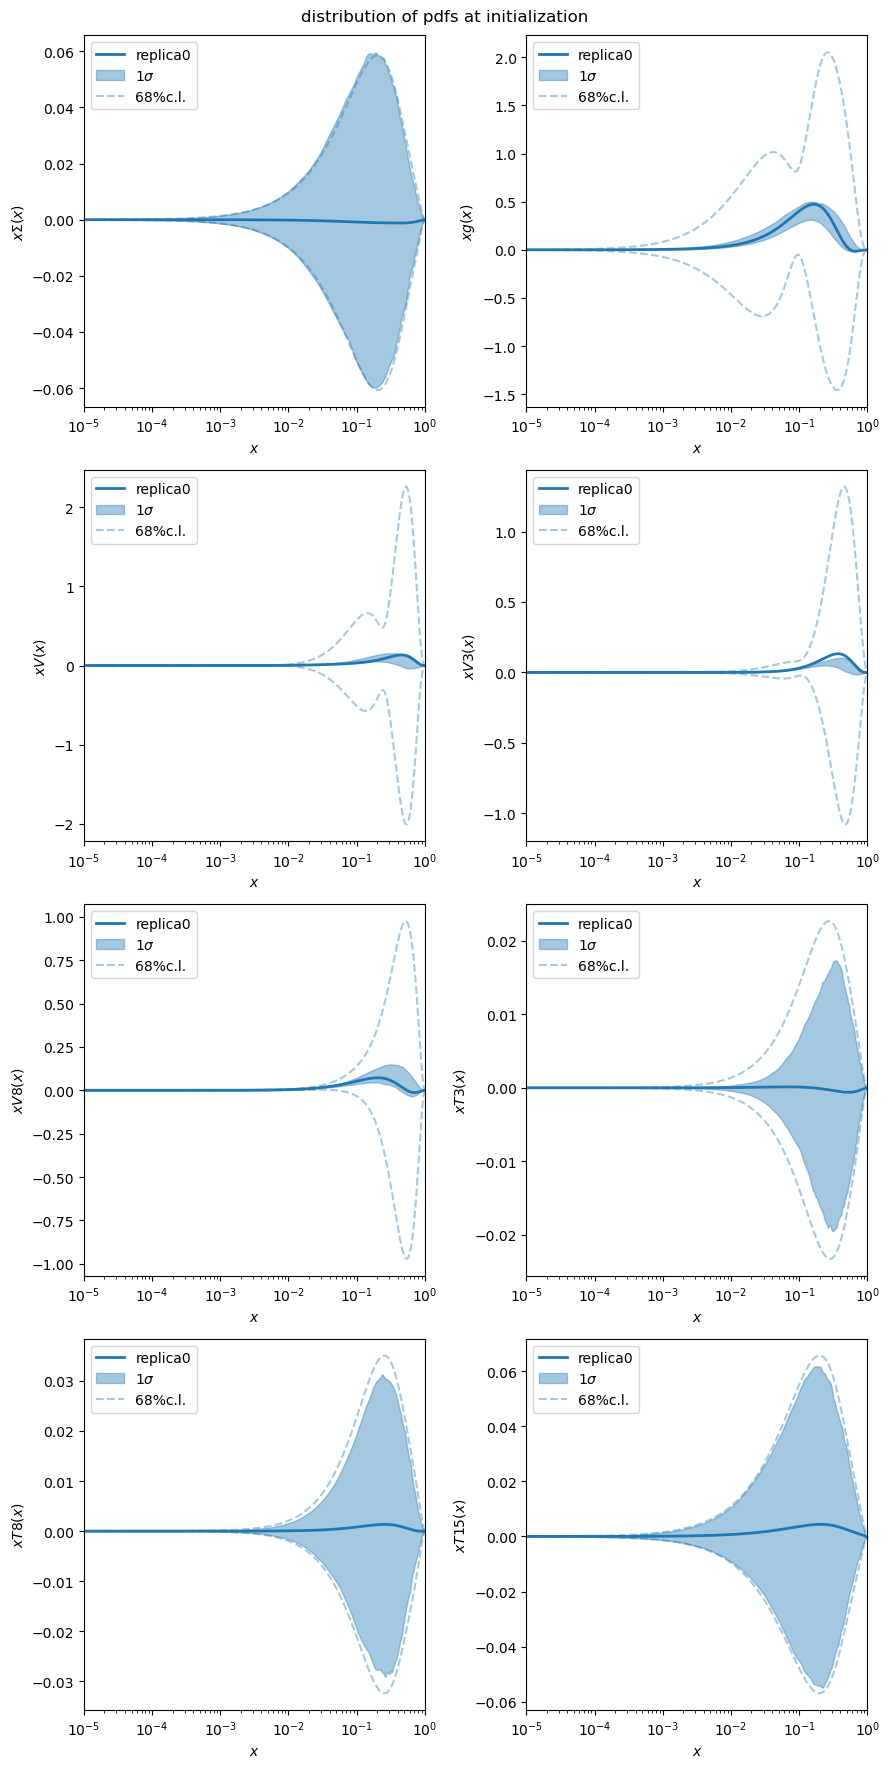

In [140]:
plt.clf()
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 18))
for i, (name, ax) in enumerate(zip(pdf_names, axs.flatten())):
    pdf_cv = nn_outputs[:,i,:].mean(axis=0)
    pdf_std = nn_outputs[:,i,:].std(axis=0)
    cl_high = np.nanpercentile(nn_outputs[:,i,:], 84, axis=0)
    cl_low = np.nanpercentile(nn_outputs[:,i,:], 16, axis=0)

    # plot rep0 PDF
    ax.plot(input_xgrid[0], input_xgrid[0]*pdf_cv, color=color, lw=2, label="replica0")

    # 68%c.l. band
    ax.fill_between(input_xgrid[0], input_xgrid[0]*cl_low, input_xgrid[0]*cl_high, alpha=0.4, color=color, label=r"1$\sigma$")

    # 1 std lines
    ax.plot(input_xgrid[0], input_xgrid[0]*(pdf_cv - pdf_std), alpha=0.4,ls="dashed", color=color)
    ax.plot(input_xgrid[0], input_xgrid[0]*(pdf_cv + pdf_std), alpha=0.4,ls="dashed", color=color, label="68%c.l.")

    ax.legend()

    ax.set_xscale("log")
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(rf"$x{name}(x)$")
    ax.set_xlim(1e-5,1)

fig.suptitle("distribution of pdfs at initialization\n")
fig.tight_layout()

# Moments

In [ ]:
# E[f_i](x)
pdfs_cv = nn_outputs.mean(axis=0).T

# Cov[f_i,f_j](x)
pdfs_cov = np.array([np.cov(nn_outputs[:,:,i].T) for i in range(XGRID.size)])

In [134]:
(((nn_outputs[:1000].mean(axis=0) - nn_outputs[:1000])**5).mean(axis=0)).max()

3605651500000.0

In [143]:
aa=np.random.randn(1000,200*8)*1
((aa.mean(axis=0) - aa)**3).mean(axis=0).max()

0.2604158058951325